In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import csv
# import umap
import scanpy as sc

def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

In [2]:
import h5py
from scipy.sparse import csr_matrix

def load_data(dataset,gene_percent_cells=0.01,peak_percent_cells=0.001,include_h5=True,
              preprocess=True,sampling=None,distance=1000000):
    
    data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)

    if sampling == 'geosketch':
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.sketch.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.sketch.h5ad'.format(dataset)))
    elif sampling == 'uniform':
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.uniform.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.uniform.h5ad'.format(dataset)))        
    else:
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.h5ad'.format(dataset)))

    if dataset == 'sci_car':
        data_dir = '/data/cb/alexwu/mm_finemap/data/sci_car'
        adata = sc.read(os.path.join(data_dir,'adata-hs.h5ad'))

        atac_adata.var['chr_no'] = ['chr' + n for n in atac_adata.var['chr_no']]
        atac_adata.var['start'] = adata.uns['atac.var'][:,2].astype(int)
        atac_adata.var['end'] = adata.uns['atac.var'][:,3].astype(int)

    if preprocess:
        # scale by maximum 
        # (rna already normalized by library size + log-transformed)
        X_max = rna_adata.X.max(0).toarray().squeeze()
        X_max[X_max == 0] = 1
        rna_adata.X = csr_matrix(rna_adata.X / X_max)

        # atac: normalize library size + log transformation
        sc.pp.normalize_total(atac_adata,target_sum=1e4)
        sc.pp.log1p(atac_adata)

    if include_h5:
        data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
        with h5py.File(os.path.join(data_dir,'dataset.h5'),'r') as f:
            print(f.keys())
            data_df = pd.DataFrame()
            for k in ['chr_no','eqtl','hic','dist','atac_id','gene','corr','group_corr','gene_percent_cells',
                      'peak_percent_cells','hg38tohg19_eqtl','eqtl.new','corr_bin','group_corr_bin',
                      'hic_0hr','hic_1hr','hic_4hr','eqtl.q','hic_4hr.expectedBL','eqtl.all','hic.new2',
                      'hic.100kb','ABC.score','hic.new']: #,
#                      'hic_0hr.expectedBL','hic_1hr.expectedBL','hic_4hr.expectedBL.new','hic_0hr.expectedBL.new',
#                      'hic_4hr.expectedBL.new2','hic_12hr.expectedBL','hic_4hr.expectedBL.full']:
                if k in f.keys():
                    data_df[k] = f[k][:]

        small_df = data_df[abs(data_df['dist']) < distance]

        # small_df = small_df[~np.isnan(small_df['group_corr'])]
        small_df = small_df[small_df['gene_percent_cells'] > gene_percent_cells]
        small_df = small_df[small_df['peak_percent_cells'] > peak_percent_cells]

        small_df.index = [(atac_idx,gene) for atac_idx,gene in small_df[['atac_id','gene']].values]
    
        return rna_adata,atac_adata,small_df

    else:
        
        return rna_adata,atac_adata

In [3]:
from scipy.stats import rankdata

def load_results(dataset,eval_df,ensemble=False,gene_percent_cells=0.01,peak_percent_cells=0.001):
    
    n_layers = 10
    n_neighbors = 15
    mode = 'lr'

    eval_df['ABC.score'] = eval_df['ABC.score'].replace(np.nan, 0)
    eval_df['ABC.score'] = eval_df['ABC.score'].values #.astype(bool).astype(float)

    eval_df['corr'] = eval_df['corr'].replace(np.nan, 0)
    eval_df['group_corr'] = eval_df['group_corr'].replace(np.nan, 0)

    data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)

    
    if dataset in ['sci_car','snare_seq']:
        
        method = 'graph'
        data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
        for trial_no in range(1,6):

            file_name = 'graph.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
            scores[np.isinf(scores)] = 10**10
            eval_df['{}.trial{}'.format(method,trial_no)] = scores
            
    elif dataset in ['share_seq_more','human_cortex_multiome_lineage']:
        
        method = 'graph'
        for trial_no in range(1,6):

            if trial_no == 1:
                data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
            else:
                data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

            if dataset == 'human_cortex_multiome_lineage':
                file_name = 'graph.uniform.250kb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            elif dataset == 'share_seq_more':
                file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            else:
                file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

            scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
            scores[np.isinf(scores)] = 10**10
            eval_df['{}.trial{}'.format(method,trial_no)] = scores
            
        
            if trial_no == 1:
                data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
            else:
                data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}_{}'.format(dataset,trial_no)

            # correlations
            with h5py.File(os.path.join(data_dir,'dataset.h5'),'r') as f:
                data_df = pd.DataFrame()
                for k in ['dist','corr','group_corr','gene_percent_cells','peak_percent_cells']:
                    if k in f.keys():
                        data_df[k] = f[k][:]

            small_df = data_df[abs(data_df['dist']) < distance]

            # small_df = small_df[~np.isnan(small_df['group_corr'])]
            small_df = small_df[small_df['gene_percent_cells'] > gene_percent_cells]
            small_df = small_df[small_df['peak_percent_cells'] > peak_percent_cells]

            eval_df['corr.trial{}'.format(trial_no)] = small_df['corr'].replace(np.nan, 0).values
            eval_df['group_corr.trial{}'.format(trial_no)] = small_df['group_corr'].replace(np.nan, 0).values

    if ensemble:
                
        for method in ['graph','corr','group_corr']:
            eval_df['{}.ranks.mean'.format(method)] = np.array([rankdata(abs(eval_df['{}.trial{}'.format(method,trial_no)].values),
                                                                method='average') for trial_no in range(1,6)]).mean(0)

        distance_ranks = rankdata(-abs(eval_df['dist'].values),method='average')
        eval_df['dist_ranks'] = distance_ranks

        for feature in ['graph.ranks.mean','group_corr.ranks.mean','corr.ranks.mean']:
            eval_df[feature + '-dist'] = (distance_ranks + eval_df[feature].values)/2
            
    return eval_df

In [4]:
from sklearn.metrics import average_precision_score,roc_auc_score

def print_results(eval_df,method_list,feature,thresh,direction,metric='auprc'):
    
    if direction == 'less':
        y_true = eval_df[feature].values <= thresh
    elif direction == 'greater':
        y_true = eval_df[feature].values >= thresh

#     print('\nBASELINE:',y_true.mean(),'----------\n')

    data_dict = {'method': [], metric: []}
    for method in method_list:
        scores = abs(eval_df[method].values)
#         if 'corr' in method:
#             scores = abs(scores)
#         elif 'dist' in method:
#             scores = -abs(scores)
                
        if metric == 'auprc':
            value = average_precision_score(y_true,scores)
        elif metric == 'auroc':
            value = roc_auc_score(y_true,scores)
#         elif metric == 'f1':
#             scores = (scores > np.percentile(scores,99)).astype(int)
#             value = f1_score(y_true,scores)
            
        auprc = average_precision_score(y_true,scores)
        data_dict['method'].append(method)
        data_dict[metric].append(value)

    results_df = pd.DataFrame(data_dict)
    results_df['trial_no'] = [int(n.split('trial')[1]) if 'trial' in n else 0 for n in results_df['method']]
    results_df['method'] = [n.split('.trial')[0] for n in results_df['method']]
    
    return results_df

In [5]:
['placseq_{}'.format(c) for c in ['eN','iN','IPC','RG']]

'''
eN: excitatory neurons
iN: interneurons
IPC: intermediate progenitor cells
RG: radial glia
'''

'\neN: excitatory neurons\niN: interneurons\nIPC: intermediate progenitor cells\nRG: radial glia\n'

In [6]:
import math

def round_sigfigs(number,significant_digits=3):
    return round(number, significant_digits - int(math.floor(math.log10(abs(number)))) - 1)

def num_sigfigs(number):
    return len(str(number).split('.')[1].strip('0'))
    
def create_plot(results_df,metric):
    
    ax = sns.barplot(x='method',y=metric,hue='method',data=results_df,capsize=0.1,dodge=False)
    plt.ylim(0,results_df[metric].max()*1.02)
    plt.xlabel('',fontsize=16)
    plt.ylabel(metric.upper(),fontsize=16)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=90)
    
    return ax
    

In [7]:
from scipy.stats import f
from statsmodels.stats.multitest import fdrcorrection

def lr_ftest(lr,n_layers,n):
    
    # number of reduced model parameters (W,b for each RNA layer)
    p1 = n_layers * 2 
    # number of full model parameters (W,b for each layer of RNA, ATAC + interaction)
    p2 = n_layers * 2 * 2 + 1 
    
    dfn = 2 * n_layers + 1
    dfd = n - 4 * n_layers - 1

    F = (lr - 1) * (n - p2)/(p2-p1)

    return 1-f.cdf(F,dfn,dfd)

def calculate_fdr(p):
    
    return fdrcorrection(p)[1]

In [8]:
def distance_matched_df(eval_df,feature,lower_thresh,negpos_ratio=9,seed=1,dist_min=2,verbose=True):
    
    df_copy = eval_df.copy()
    np.random.seed(1)
    
    dist_categories = np.clip(np.log10(0.1+abs(df_copy['dist'].values)).astype(int),dist_min,10)
    df_copy['dist_category'] = dist_categories

    df_list = []
    for group,group_df in df_copy.groupby('dist_category'):
        
        n_per_category = (group_df[feature] <= lower_thresh).sum()
        pos_inds = np.argsort(group_df[feature])[0:n_per_category].tolist()
        neg_inds = np.argsort(group_df[feature])[(-negpos_ratio*n_per_category):]
        neg_inds = list(set(neg_inds) - set(pos_inds))
        
        if verbose:
            print(group,len(pos_inds),len(neg_inds))
        
        df_list.append(group_df.iloc[pos_inds + neg_inds])
    
    return pd.concat(df_list)

In [9]:
def convert_name(n):
    
    if 'graph' in n:
        name = 'GrID-Net'
    elif 'group' in n:
        name = 'Pseudocell Corr'
    elif 'corr' in n:
        name = 'Correlation'
    elif 'ABC' in n:
        name = 'ABC'
    elif "GVAR" in n or "gvar" in n:
        name = "GVAR"
    elif "granger" in n:
        name = "Granger"
    
    
    if 'rra' in n:
        name += ' (RRA)'
        
    if 'ranks' in n:
        name += ' (ens)'
    
    if '-dist' in n:
        name += ' (dist)'
        

    return name

## Results

In [10]:
dataset = 'human_cortex_multiome_lineage'

distance = 250000
gene_percent_cells = 0.01
peak_percent_cells = 0.001

rna_adata,atac_adata,eval_df = load_data(dataset,gene_percent_cells=gene_percent_cells,
                                          peak_percent_cells=peak_percent_cells,
                                          include_h5=True,sampling='uniform',distance=distance)

eval_df = load_results(dataset,eval_df,ensemble=True)
eval_df['abs_dist'] = abs(eval_df['dist'])

Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
<KeysViewHDF5 ['ABC.score', 'atac_id', 'chr_no', 'corr', 'dist', 'eqtl.all', 'eqtl.fdr', 'eqtl.gtex', 'gene', 'gene_percent_cells', 'group_corr', 'hic', 'hic.new', 'peak_percent_cells', 'placseq_IPC', 'placseq_RG', 'placseq_eN', 'placseq_iN']>


In [11]:
# load standard Granger + GVAR results
dataset = 'human_cortex_multiome_lineage'

# Granger
data_dir = "/data/cb/alexwu/mm_finemap/results/tests_nn"
df = pd.read_csv(os.path.join(data_dir,dataset,"{}.standard_granger.csv".format(dataset)))
eval_df["granger.trial{}".format(1)] = -np.log10(df["granger_p"].values)
for trial_no in range(2,6):
    df = pd.read_csv(os.path.join(data_dir,"{}_{}".format(dataset,trial_no),"{}_{}.standard_granger.csv".format(dataset,trial_no)))
    eval_df["granger.trial{}".format(trial_no)] = -np.log10(df["granger_p"].values)
    eval_df["granger.trial{}".format(trial_no)] = eval_df["granger.trial{}".format(trial_no)].replace(np.nan,0)

# GVAR
# df = pd.read_csv(os.path.join(data_dir,dataset,"{}.GVAR.csv".format(dataset,trial_no)))
# p = [float(n.strip("[]")) for n in df["granger_p"].values]
# eval_df["gvar.trial{}".format(1)] = -np.log10(df["granger_p"].values)
for trial_no in range(2,6):
    df = pd.read_csv(os.path.join(data_dir,"{}_{}".format(dataset,trial_no),"{}_{}.GVAR.csv".format(dataset,trial_no)))
    p = [float(n.strip("[]")) for n in df["granger_p"].values]
    eval_df["gvar.trial{}".format(trial_no)] = -np.log10(p)

### No Ensembling

In [39]:
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])]

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]

eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,dist_min=2)

eval_df_hic = eval_df.copy() #.iloc[inds2keep]

eval_df_hic = eval_df[~eval_df['hic.new'].isna()]
eval_df_hic = eval_df_hic[eval_df_hic['hic.new'] != 0]
eval_df_hic['hic.new.rev'] = -eval_df_hic['hic.new'].values
hic_lower_thresh = -np.percentile(eval_df_hic['hic.new'],99)
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]

eval_df_hic = distance_matched_df(eval_df_hic,'hic.new.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

/tmp/ipykernel_3989144/3671073141.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]


2 18 18
3 29 29
4 60 60
5 30 30
5 13187 13187


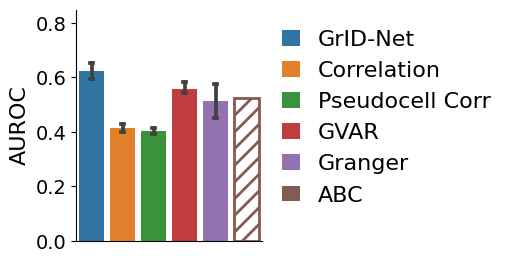

In [43]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['ABC.score']

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.rcParams['hatch.linewidth'] = 2
ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
ax.patches[-1].set_facecolor('white')
ax.patches[-1].set_hatch('//')
ax.patches[-1].set_linewidth(2)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
sns.despine()

plt.ylim([0,0.85])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.eqtl.0324.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")

plt.show()

In [41]:
results_df.groupby("method")["auroc"].mean()

method
ABC                0.524775
Correlation        0.414311
GVAR               0.559300
GrID-Net           0.625420
Granger            0.514178
Pseudocell Corr    0.402376
Name: auroc, dtype: float64

In [42]:
(0.625420-0.559300)/0.559300

0.1182192025746468

In [44]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=10.726184028094412, pvalue=2.5002957973543688e-05)
------
Pseudocell Corr
Ttest_indResult(statistic=11.960079030782047, pvalue=4.385855750939093e-05)
------
GVAR
Ttest_indResult(statistic=3.061400884136058, pvalue=0.009626004169421864)
------
Granger
Ttest_indResult(statistic=2.5873346918856854, pvalue=0.022132349690200115)
------


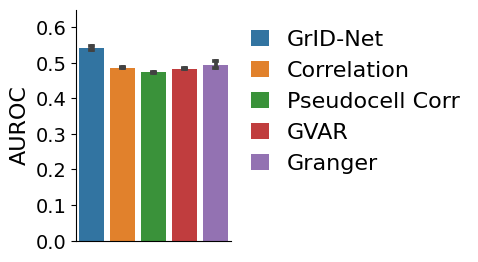

In [45]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]
# method_list += ['ABC.score']

feature = 'hic.new.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]

results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
sns.despine()

plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.hic.0324.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")

plt.show()

In [46]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=18.97713260738382, pvalue=2.218074381567859e-06)
------
Pseudocell Corr
Ttest_indResult(statistic=23.49253118823798, pvalue=5.829056702198008e-07)
------
GVAR
Ttest_indResult(statistic=19.01550854945136, pvalue=8.096919170453584e-07)
------
Granger
Ttest_indResult(statistic=6.884417782666566, pvalue=0.0003493946651624076)
------


### Intersection of eQTL & Hi-C

In [64]:
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])]

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]

# eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,dist_min=2)

eval_df_hic = eval_df.copy() #.iloc[inds2keep]

eval_df_hic = eval_df[~eval_df['hic.new'].isna()]
eval_df_hic = eval_df_hic[eval_df_hic['hic.new'] != 0]
eval_df_hic['hic.new.rev'] = -eval_df_hic['hic.new'].values
hic_lower_thresh = -np.percentile(eval_df_hic['hic.new'],95)

# eval_df_hic = distance_matched_df(eval_df_hic,'hic.new.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

/tmp/ipykernel_3989144/753024627.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]


In [65]:
idx2keep = list(set(eval_df_hic.index.values) & set(eval_df_eqtl.index.values))

eval_df_eqtl_hic = eval_df_hic.loc[idx2keep]
eval_df_eqtl_hic["eqtl_hic_thresh"] = ((eval_df_eqtl_hic["hic.new.rev"] < hic_lower_thresh) & (eval_df_eqtl_hic["eqtl.all"] < eqtl_lower_thresh)).astype(float)

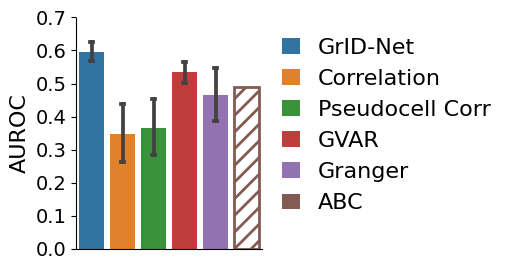

In [71]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['ABC.score']

feature = 'eqtl_hic_thresh'
direction = 'greater'

metric = 'auroc'
results_df = print_results(eval_df_eqtl_hic,method_list,feature,0.5,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]

# results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.rcParams['hatch.linewidth'] = 2
ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
ax.patches[-1].set_facecolor('white')
ax.patches[-1].set_hatch('//')
ax.patches[-1].set_linewidth(2)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=True)
sns.despine()

plt.ylim([0,0.7])
plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
plt.savefig(os.path.join(plot_dir,'auroc','{}.eqtl_hic_intersection.0324.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

In [37]:
from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

Correlation
Ttest_indResult(statistic=4.76513008137533, pvalue=0.002554009149087434)
------
Pseudocell Corr
Ttest_indResult(statistic=4.384068095180401, pvalue=0.003628651878712646)
------
GVAR
Ttest_indResult(statistic=2.418774941384567, pvalue=0.024043928350934454)
------
Granger
Ttest_indResult(statistic=2.627125413074127, pvalue=0.022962929537303865)
------


### Ensembling

In [16]:
eqtl_lower_thresh = 1e-3
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])]
# eval_df_eqtl = eval_df_eqtl[abs(eval_df_eqtl['dist']) > 100000]
eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,dist_min=2)


# if 'placseq' in eval_df.columns:
#     del eval_df['placseq']
    
# # most significant link across different cell types
# placseq_features = [n for n in eval_df.columns if 'placseq' in n and 'iN' not in n]
# placseq_values = np.nanmax(-np.log10(eval_df[placseq_features].values),axis=1)
# placseq_values[np.isnan(placseq_values)] = 0
# eval_df['placseq'] = placseq_values #.astype(bool).astype(float)

# eval_df_placseq = eval_df[eval_df['placseq'] != 0].copy()
# eval_df_placseq['placseq.rev'] = -eval_df_placseq['placseq'].values
# placseq_lower_thresh = -np.percentile(eval_df_placseq['placseq'],90)
# eval_df_placseq = distance_matched_df(eval_df_placseq,'placseq.rev',placseq_lower_thresh,negpos_ratio=4,seed=1)

2 120 120
3 203 203
4 964 964
5 547 547


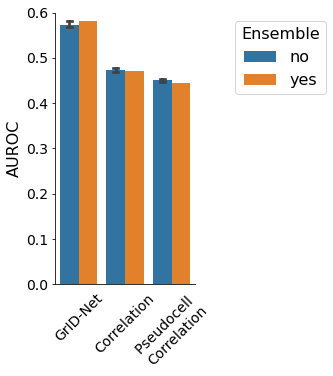

In [17]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)] #+ \
method_list += ['graph.ranks.mean','group_corr.ranks.mean','corr.ranks.mean']
# method_list += ['ABC.score'] #,'dist_ranks']

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)
results_df['method'] = [convert_name(n) for n in results_df['method']]

results_df['ens'] = ['yes' if '(ens)' in n else 'no' for n in results_df['method']]
results_df['method'] = [n.split(' (')[0] for n in results_df['method']]
results_df['method'] = ['Pseudocell \nCorrelation' if 'Pseudo' in n else n for n in results_df['method']]

plt.figure(figsize=(2.5,5))
sns.barplot(x='method',y=metric,hue='ens',data=results_df,capsize=0.1,dodge=True)
plt.ylim(0,results_df[metric].max()*1.02)
plt.xlabel('',fontsize=16)
plt.ylabel(metric.upper(),fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14,rotation=45)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(2,1),fontsize=16,title='Ensemble',title_fontsize=16,frameon=True)
sns.despine()
plt.show()

### eQTL (1e-3)

/tmp/ipykernel_3519835/1408412938.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]


2 120 120
3 203 203
4 964 964
5 547 547
5 13187 13187


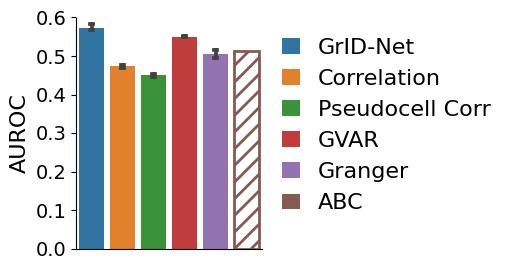

Correlation
Ttest_indResult(statistic=21.100166804295725, pvalue=1.2972464894350097e-07)
------
Pseudocell Corr
Ttest_indResult(statistic=27.407344953522383, pvalue=1.0760357140273237e-07)
------
GVAR
Ttest_indResult(statistic=5.719055675223977, pvalue=0.0017644186709630757)
------
Granger
Ttest_indResult(statistic=8.894874983442035, pvalue=3.0764566765413625e-05)
------


In [27]:
eqtl_lower_thresh = 1e-3
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])]

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]

eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,dist_min=2)

eval_df_hic = eval_df.copy() #.iloc[inds2keep]

eval_df_hic = eval_df[~eval_df['hic.new'].isna()]
eval_df_hic = eval_df_hic[eval_df_hic['hic.new'] != 0]
eval_df_hic['hic.new.rev'] = -eval_df_hic['hic.new'].values
hic_lower_thresh = -np.percentile(eval_df_hic['hic.new'],99)
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]

eval_df_hic = distance_matched_df(eval_df_hic,'hic.new.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)] + \
                ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['ABC.score']

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = [convert_name(n) for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
plt.rcParams['hatch.linewidth'] = 2
ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
ax.patches[-1].set_facecolor('white')
ax.patches[-1].set_hatch('//')
ax.patches[-1].set_linewidth(2)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.eqtl.1e-3.0324.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")

plt.ylim([0,0.6])

plt.show()

from scipy.stats import ttest_ind

for method in ["Correlation","Pseudocell Corr","GVAR","Granger"]:
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

### Robustness
#### Highly Variable Genes

In [14]:
n_layers = 10
n_neighbors = 15

method = 'graph'
for trial_no in range(1,6):

    if trial_no == 1:
        data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
    else:
        data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

    if dataset == 'human_cortex_multiome_lineage':
        file_name = 'graph.uniform.250kb.hv4000.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
    elif dataset == 'share_seq_more':
        file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
    else:
        file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

    scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
    scores[np.isinf(scores)] = 10**10
    eval_df['{}.hv4000.trial{}'.format(method,trial_no)] = scores

#### Number of Neighbors

In [15]:
n_layers = 10

method = 'graph'
for trial_no in range(1,6):

    for n_neighbors in [5,25]:
        if trial_no == 1:
            data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
        else:
            data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

        if dataset == 'human_cortex_multiome_lineage':
            file_name = 'graph.uniform.250kb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
        elif dataset == 'share_seq_more':
            file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
        else:
            file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

        scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
        scores[np.isinf(scores)] = 10**10
        eval_df['{}.nn{}.trial{}'.format(method,n_neighbors,trial_no)] = scores

#### Plots

In [18]:
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])]

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]

eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,dist_min=2)

eval_df_hic = eval_df.copy() #.iloc[inds2keep]

eval_df_hic = eval_df[~eval_df['hic.new'].isna()]
eval_df_hic = eval_df_hic[eval_df_hic['hic.new'] != 0]
eval_df_hic['hic.new.rev'] = -eval_df_hic['hic.new'].values
hic_lower_thresh = -np.percentile(eval_df_hic['hic.new'],99)
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]

eval_df_hic = distance_matched_df(eval_df_hic,'hic.new.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

/tmp/ipykernel_3989144/3671073141.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]


2 18 18
3 29 29
4 60 60
5 30 30
5 13187 13187


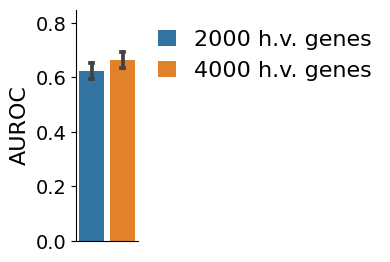

In [24]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.hv4000.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = ["2000 h.v. genes" if "hv" not in n else "4000 h.v. genes" for n in results_df['method']] # [convert_name(n) for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
sns.despine()

plt.ylim([0,0.85])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.robustness.hv_genes.eqtl.0524.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

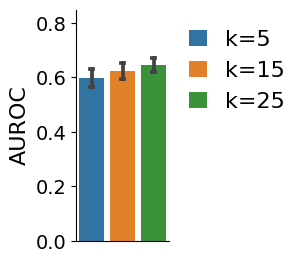

In [25]:
method_list = ['graph.nn5.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.nn25.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = ["k={}".format(n.split(".nn")[1]) if "nn" in n else "k=15" 
                        for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
sns.despine()

plt.ylim([0,0.85])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.robustness.n_neighbors.eqtl.0524.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

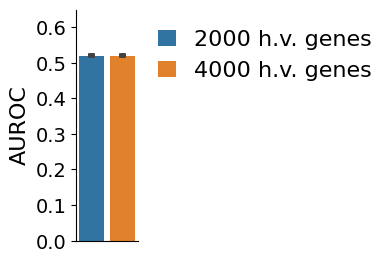

In [36]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.hv4000.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'hic.new.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)

results_df['method'] = ["2000 h.v. genes" if "hv" not in n else "4000 h.v. genes" for n in results_df['method']] # [convert_name(n) for n in results_df['method']]
plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
# plt.rcParams['hatch.linewidth'] = 2
# ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
# ax.patches[-1].set_facecolor('white')
# ax.patches[-1].set_hatch('//')
# ax.patches[-1].set_linewidth(2)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
sns.despine()

plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.robustness.hv_genes.hic.0524.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

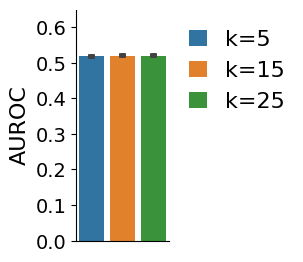

In [37]:
method_list = ['graph.nn5.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['graph.nn25.trial{}'.format(trial_no) for trial_no in range(1,6)]

feature = 'hic.new.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)

results_df['method'] = ["k={}".format(n.split(".nn")[1]) if "nn" in n else "k=15" 
                        for n in results_df['method']]
plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = create_plot(results_df,metric)
# plt.rcParams['hatch.linewidth'] = 2
# ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
# ax.patches[-1].set_facecolor('white')
# ax.patches[-1].set_hatch('//')
# ax.patches[-1].set_linewidth(2)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
sns.despine()

plt.ylim([0,0.65])

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.robustness.n_neighbors.hic.0524.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

### Sparse Genes, Peaks

In [12]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['group_corr.trial{}'.format(trial_no) for trial_no in range(1,6)]
method_list += ['gvar.trial{}'.format(trial_no) for trial_no in range(2,6)]
method_list += ['granger.trial{}'.format(trial_no) for trial_no in range(1,6)]

# method_list += ['ABC.score'] #,'dist_ranks']

In [13]:
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])]

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]

eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,dist_min=2)

eval_df_hic = eval_df.copy() #.iloc[inds2keep]

eval_df_hic = eval_df[~eval_df['hic.new'].isna()]
eval_df_hic = eval_df_hic[eval_df_hic['hic.new'] != 0]
eval_df_hic['hic.new.rev'] = -eval_df_hic['hic.new'].values
hic_lower_thresh = -np.percentile(eval_df_hic['hic.new'],99)
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]

eval_df_hic = distance_matched_df(eval_df_hic,'hic.new.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

/tmp/ipykernel_2527613/3671073141.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]


2 18 18
3 29 29
4 60 60
5 30 30
5 13187 13187


In [20]:
results_df_list = []
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()

# method_list = ['{}.trial{}'.format(method,trial_no) for method in ['graph','corr','group_corr'] for trial_no in range(1,6)]

for bin_start,bin_end in [(0.,0.1),(0.1,0.2),(0.2,0.5)]:

    eqtl_lower_thresh = 1e-10
    eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()

    # FDR correction
    from statsmodels.stats.multitest import fdrcorrection
    eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]
        
    eval_df_eqtl = eval_df_eqtl[(eval_df_eqtl['gene_percent_cells'] > bin_start) & (eval_df_eqtl['gene_percent_cells'] < bin_end)]
    eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,verbose=False)
    print(eval_df_eqtl.shape[0])
    
    feature = 'eqtl.all'
    direction = 'less'

    metric = 'auroc'
    results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

    results_df['method'] = [convert_name(n) for n in results_df['method']]
    results_df['percent_cells'] = ["{:.0f} - {:.0f}%".format(100*bin_start,100*bin_end) for i in range(results_df.shape[0])]
    results_df_list.append(results_df)
results_df = pd.concat(results_df_list)

92
68
114


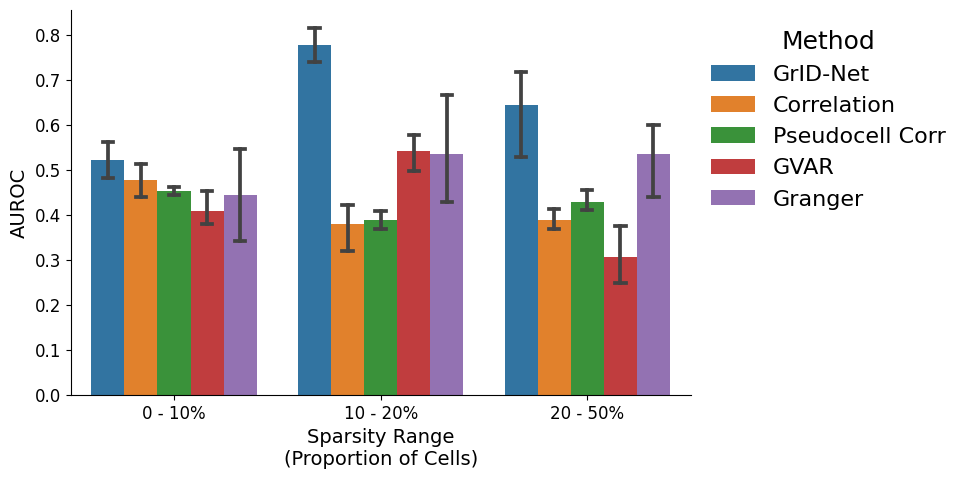

In [21]:
plot_dir = '/data/cb/alexwu/mm_finemap/figures'

plt.figure(figsize=(8,5))
sns.barplot(x="percent_cells",y="auroc",hue="method",data=results_df,capsize=0.05)
plt.xlabel("Sparsity Range\n(Proportion of Cells)",fontsize=14)
plt.ylabel("AUROC",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16,bbox_to_anchor=(1,1),title='Method',title_fontsize=18,frameon=False)
sns.despine()
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.sparsity_genes.eqtl.0524.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

In [17]:
# method_list = ["{}.trial{}".format(method,trial_no) for method in ['graph','corr','group_corr'] for trial_no in range(1,6)]

results_df_list = []
# eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()
for bin_start,bin_end in [(0.,0.01),(0.01,0.05),(0.05,0.1)]:

    eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()
    
    # FDR correction
    from statsmodels.stats.multitest import fdrcorrection
#     eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]

    eval_df_eqtl = eval_df_eqtl[(eval_df_eqtl['peak_percent_cells'] > bin_start) & (eval_df_eqtl['peak_percent_cells'] < bin_end)]
    eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,verbose=False)
    
    feature = 'eqtl.all'
    direction = 'less'

    metric = 'auroc'
    results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

    results_df['method'] = [convert_name(n) for n in results_df['method']]
    results_df['percent_cells'] = ["{:.0f} - {:.0f}%".format(100*bin_start,100*bin_end) for i in range(results_df.shape[0])]
    results_df_list.append(results_df)
results_df = pd.concat(results_df_list)

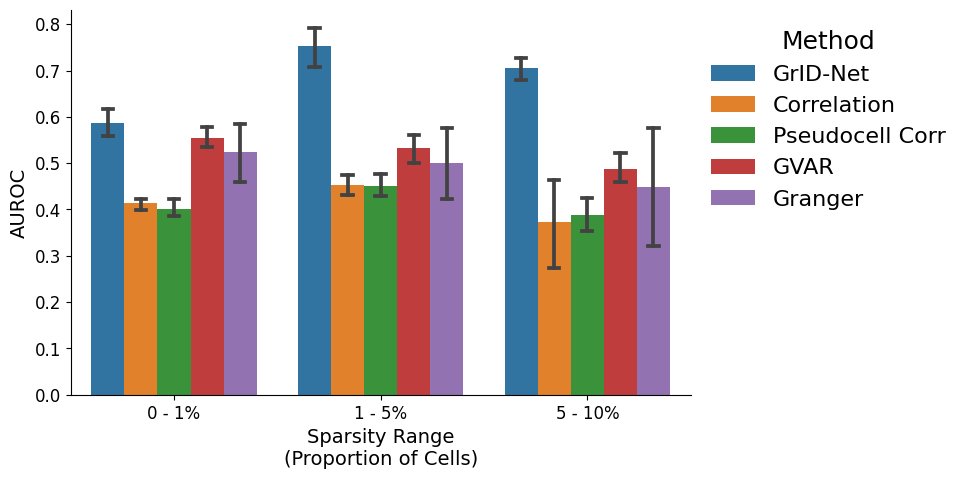

In [19]:
plot_dir = '/data/cb/alexwu/mm_finemap/figures'

plt.figure(figsize=(8,5))
sns.barplot(x="percent_cells",y="auroc",hue="method",data=results_df,capsize=0.05)
plt.xlabel("Sparsity Range\n(Proportion of Cells)",fontsize=14)
plt.ylabel("AUROC",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16,bbox_to_anchor=(1,1),title='Method',title_fontsize=18,frameon=False)
sns.despine()
plt.savefig(os.path.join(plot_dir,'auroc','updated.{}.sparsity_peaks.eqtl.0524.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
plt.show()

In [18]:
results_df_list = []
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()
for percent in np.linspace(0.1,0.5,25):

    eqtl_lower_thresh = 1e-3
    eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()
    eval_df_eqtl = eval_df_eqtl[eval_df_eqtl['gene_percent_cells'] < percent]
    eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,verbose=False)
    
    method_list = ['graph.ranks.mean','corr.ranks.mean','group_corr.ranks.mean']

    feature = 'eqtl.all'
    direction = 'less'

    metric = 'auroc'
    results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

    results_df['method'] = [convert_name(n) for n in results_df['method']]
    results_df['percent_cells'] = percent
    results_df_list.append(results_df)
results_df = pd.concat(results_df_list)

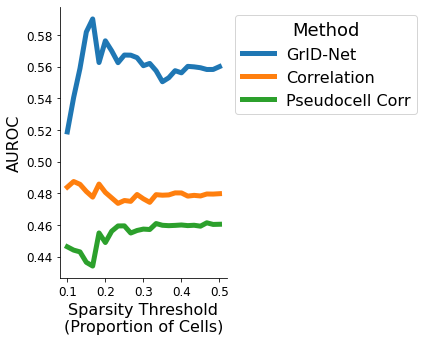

In [19]:
plt.figure(figsize=(3,5))
for method_name in ['GrID-Net','Correlation','Pseudocell Corr']:
    group_df = results_df[results_df['method'] == method_name + ' (ens)']
    plt.plot(group_df['percent_cells'],group_df[metric],label=method_name,lw=5)
    
plt.xlabel('Sparsity Threshold\n(Proportion of Cells)',fontsize=16)
plt.ylabel(metric.upper(),fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=16,bbox_to_anchor=(1,1),title='Method',title_fontsize=18)
sns.despine()
plt.show()

#### Sparse Peaks

In [20]:
results_df_list = []
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()
for percent in np.linspace(0.01,0.1,25):

    eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()
    eval_df_eqtl = eval_df_eqtl[eval_df_eqtl['peak_percent_cells'] < percent]
    eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1,verbose=False)
    
    method_list = ['graph.ranks.mean','corr.ranks.mean','group_corr.ranks.mean']

    feature = 'eqtl.all'
    direction = 'less'

    metric = 'auprc'
    results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

    results_df['method'] = [convert_name(n) for n in results_df['method']]
    results_df['percent_cells'] = percent
    results_df_list.append(results_df)
results_df = pd.concat(results_df_list)

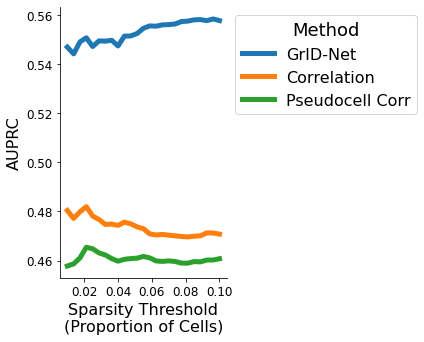

In [21]:
plt.figure(figsize=(3,5))
for method_name in ['GrID-Net','Correlation','Pseudocell Corr']:
    group_df = results_df[results_df['method'] == method_name + ' (ens)']
    plt.plot(group_df['percent_cells'],group_df[metric],label=method_name,lw=5)
    
plt.xlabel('Sparsity Threshold\n(Proportion of Cells)',fontsize=16)
plt.ylabel(metric.upper(),fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=16,bbox_to_anchor=(1,1),title='Method',title_fontsize=18)
sns.despine()
plt.show()

### Ensembling: RRA

In [16]:

data_dir = '/data/cb/alexwu/mm_finemap/results/RRA/{}'.format(dataset)
include_dist = False

for method in ['graph','corr','group_corr']:
    
    dist = int(include_dist)
    
    df = pd.read_csv(os.path.join(data_dir,'RRA.{}.dist{}.csv'.format(method,dist)))
    
    df.index = [(int(n.split('->')[0]),n.split('->')[1]) for n in df['Name'].values]
    df = df.loc[eval_df.index.values]
    
    eval_df['{}.rra'.format(method)] = -np.log10(df['Score'].values)

## Logistic Regression: Include Distance

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score,roc_auc_score

def nested_cross_validation_datasets(eval_df,feature,lower_thresh,negpos_ratio,n_folds=3,dist_min=2,seed=1):
    
    df_copy = eval_df.copy()
    
    dist_categories = np.clip(np.log10(0.1+abs(df_copy['dist'].values)).astype(int),dist_min,10)
    df_copy['dist_category'] = dist_categories
    df_copy['label'] = (df_copy[feature] < lower_thresh).values.astype(float)
    
    df_list = []
    for group,group_df in df_copy.groupby(['dist_category','label']):
        group_df['fold'] = np.arange(group_df.shape[0]) % n_folds
        df_list.append(group_df)
    df = pd.concat(df_list)
    
    # validation set
    validation_df = df[df['fold'] == 0]
    inner_df = df[df['fold'] != 0]
    
    # inner loop training, test sets
    inner_df_list = []
    for group,group_df in inner_df.groupby(['dist_category','label']):
        group_df['fold'] = np.arange(group_df.shape[0]) % n_folds
        inner_df_list.append(group_df)
    inner_df = pd.concat(inner_df_list)
        
    inner_df_sets = []
    for fold_no in range(n_folds):
        test_df = inner_df[inner_df['fold'] == fold_no]
        train_df = inner_df[inner_df['fold'] != fold_no]
    
        inner_df_sets.append((train_df,test_df))
        
    return validation_df,inner_df_sets

def transform_X(df,score_key):

#     X = df[[score_key,'log_dist']].values
    X = np.array([np.log(1e-10+df[score_key]),np.clip(np.log10(1+df['abs_dist']),4,10)-4]).T
#     X = np.log10(1e-5 + df[[score_key,'abs_dist']].values)

    return X

def nested_cross_validation(inner_df_sets,score_key,feature,lower_thresh,metric='auroc'):
    
    model_list = []
    metric_list = []
    
    for train_df,test_df in inner_df_sets:
                
        train_X = transform_X(train_df,score_key)
        train_y = (train_df[feature] < lower_thresh).astype(float)
        
        test_X = transform_X(test_df,score_key)
        test_y = (test_df[feature] < lower_thresh).astype(float)

        lr = LogisticRegression(penalty='none',fit_intercept=True).fit(train_X,train_y)
        
        if metric == 'auroc':
            metric_list.append(roc_auc_score(test_y,lr.predict_proba(test_X)[:,1]))
        elif metric == 'auprc':
            metric_list.append(average_precision_score(test_y,lr.predict_proba(test_X)[:,1]))
        
        model_list.append(lr)
        
    return model_list[np.argmax(metric_list)]

def validation_predictions(validation_df,selected_model,score_key,feature,lower_thresh):
    
    validation_X = transform_X(validation_df,score_key)
    validation_y = (validation_df[feature] < lower_thresh).astype(float)

    validation_df[score_key + '-dist-LR'] = selected_model.predict_proba(validation_X)[:,1]

In [21]:
eval_df['abs_dist'] = abs(eval_df['dist'])

In [22]:
# for col in eval_df.columns:
#     if 'ranks.mean' in col and 'rerank' not in col:
#         eval_df[col + '.rerank'] = rankdata(eval_df[col],method='average')

### Train/Test on Cortex

In [23]:
n_folds = 3
feature = 'eqtl.all'
negpos_ratio = 1
direction = 'less'

validation_df,inner_df_sets = nested_cross_validation_datasets(eval_df_eqtl,feature,eqtl_lower_thresh,
                                                              negpos_ratio,n_folds=n_folds,seed=1)

# method_list = ['graph.ranks.mean.norm','group_corr.ranks.mean.norm','corr.ranks.mean.norm']
method_list = ['{}.ranks.mean'.format(method) for method in ['graph','corr','group_corr']]

for score_key in method_list:
    selected_lr = nested_cross_validation(inner_df_sets,score_key,feature,eqtl_lower_thresh)
    print(score_key,selected_lr.coef_,selected_lr.intercept_)
    validation_predictions(validation_df,selected_lr,score_key,feature,eqtl_lower_thresh)

graph.ranks.mean [[ 0.28477297 -0.30116235]] [-3.51950391]
corr.ranks.mean [[-0.07157329 -0.32122383]] [1.19189322]
group_corr.ranks.mean [[-0.24343977 -0.33195939]] [3.50651854]


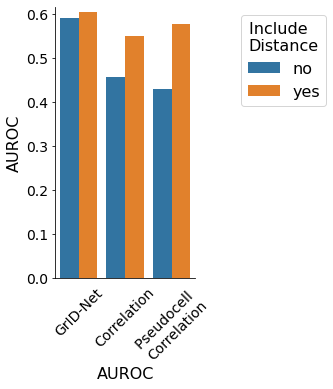

In [24]:
# method_list = ['graph.ranks.mean','group_corr.ranks.mean','corr.ranks.mean']
method_list = ['{}.ranks.mean'.format(method) for method in ['graph','corr','group_corr']]
method_list += ['{}-dist-LR'.format(n) for n in method_list]

metric = 'auroc'
results_df = print_results(validation_df,method_list,feature,eqtl_lower_thresh,direction,metric=metric)
results_df['method'] = [convert_name(n) for n in results_df['method']]

results_df['dist'] = ['yes' if '(dist)' in n else 'no' for n in results_df['method']]
results_df['method'] = [n.split(' (')[0] for n in results_df['method']]
results_df['method'] = ['Pseudocell \nCorrelation' if 'Pseudo' in n else n for n in results_df['method']]

plt.figure(figsize=(2.5,5))
sns.barplot(x='method',y=metric,hue='dist',data=results_df,capsize=0.1,dodge=True)
plt.ylim(0,results_df[metric].max()*1.02)
plt.xlabel(metric.upper(),fontsize=16)
plt.ylabel(metric.upper(),fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14,rotation=45)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(2,1),fontsize=16,title='Include \nDistance',title_fontsize=16,frameon=True)
sns.despine()
plt.show()

### Transfer from SHARE-seq

In [26]:
eqtl_lower_thresh = 1e-3
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()
eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.all',eqtl_lower_thresh,negpos_ratio=1,seed=1)

# # min-max normalize rankings
# for col in eval_df_eqtl.columns:
#     if 'ranks.mean' in col:
#         min_value = eval_df[col].min()
#         max_value = eval_df[col].max()
#         eval_df_eqtl['{}.norm'.format(col)] = np.log(1+(eval_df_eqtl[col] - min_value)/(max_value-min_value))

2 120 120
3 203 203
4 964 964
5 547 547


In [27]:
def string2coeffs(coeff_str):
    
    values = np.array([float(v) for v in [n.strip('[ ]') 
                        for n in coeff_str.split(' ')] if len(v)])
    
    return np.array([values[0:2]]),np.array([values[2]])

lr = LogisticRegression(penalty='none',fit_intercept=True)

coeff_str = '[[ 0.28047717 -0.3394994 ]] [-3.62364303]'
coeff_str = '[[ 0.28332471 -0.16272753]] [-3.66021169]'

lr.coef_,lr.intercept_ = string2coeffs(coeff_str)
lr.classes_ = np.array([0,1])

In [28]:
eqtl_lower_thresh = 1e-3

for method in ['graph','corr','group_corr']:
    
    score_key = '{}.ranks.mean'.format(method)

    X = transform_X(eval_df_eqtl,score_key)
    y = (eval_df_eqtl[feature] < eqtl_lower_thresh).astype(float)

    print(roc_auc_score(y,X[:,0]),roc_auc_score(y,lr.predict_proba(X)[:,1]))
    validation_predictions(eval_df_eqtl,lr,score_key,feature,eqtl_lower_thresh)


0.5814310806777114 0.5914719421945107
0.4709102509368062 0.49276688124116264
0.4441439357632221 0.4671214036573198


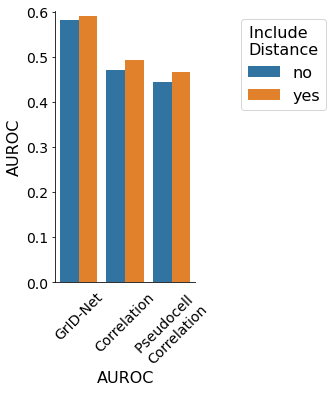

In [29]:
# method_list = ['graph.ranks.mean','group_corr.ranks.mean','corr.ranks.mean']
# method_list += ['{}.norm-dist-LR'.format(n) for n in method_list]

method_list = ['{}.ranks.mean'.format(method) for method in ['graph','corr','group_corr']]
method_list += ['{}-dist-LR'.format(n) for n in method_list]


metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)
results_df['method'] = [convert_name(n) for n in results_df['method']]

results_df['dist'] = ['yes' if '(dist)' in n else 'no' for n in results_df['method']]
results_df['method'] = [n.split(' (')[0] for n in results_df['method']]
results_df['method'] = ['Pseudocell \nCorrelation' if 'Pseudo' in n else n for n in results_df['method']]

plt.figure(figsize=(2.5,5))
sns.barplot(x='method',y=metric,hue='dist',data=results_df,capsize=0.1,dodge=True)
plt.ylim(0,results_df[metric].max()*1.02)
plt.xlabel(metric.upper(),fontsize=16)
plt.ylabel(metric.upper(),fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14,rotation=45)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(bbox_to_anchor=(2,1),fontsize=16,title='Include \nDistance',title_fontsize=16,frameon=True)
sns.despine()
plt.show()